In [ ]:
#Applicable only if you are building it on Google Drive
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi
%cd /content/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Jul 28 14:42:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:

"""
Created on Sun Jun 27 12:06:36 2021
@author: zaher
"""

from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
# import cv2
# from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random



# setting the root directories and categories of the images
root_dir_train = '/content/drive/MyDrive/ColabNotebooks/train/'
categories_train = [[folder] for folder in os.listdir(root_dir_train)  if not folder.startswith('.') ] # for MMUII
root_dir_test = '/content/drive/MyDrive/ColabNotebooks/test/'
categories_test = [[folder] for folder in os.listdir(root_dir_test)  if not folder.startswith('.') ] # for MMUII



In [ ]:

# creating images pairs as inputs
# images for same subject (person) = 1, otherwise = 0

class irisDataset(Dataset):
    def __init__(self, categories_train, root_dir_train, dataSize, transform=None):
        self.categories_train = categories_train
        self.root_dir_train = root_dir_train
        self.transform = transform
        self.dataSize = dataSize
    def __len__(self):
        return self.dataSize
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        if idx % 2 == 0: # select a similiar IRIS for both images
                         # positive_data_loader > similar images and vice versa

            category = random.choice(categories_train)
            imgDir = root_dir_train + category[0]
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)
            # print(imgDir+'/'+img1Name)
            # print(imgDir+'/'+img2Name)
            label = 1.0 # Iris Images for same person
            
        else: # select a different IRIS for both images
            class_1, class_2 = random.choice(categories_train), random.choice(categories_train)
            imgDir1, imgDir2 = root_dir_train + class_1[0] , root_dir_train + class_2[0]
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0 # Iris Images for different persons
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
        # plt.imshow(img1)
        
        img1 = img1.convert("L")
        img2 = img2.convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))


# creates n-way one shot learning evaluation

class NWaysEval(Dataset):
    def __init__(self, categories_test, root_dir_test, dataSize, numberOfWays, transform=None):
        self.categories_test = categories_test
        self.root_dir_test = root_dir_test
        self.dataSize = dataSize
        self.numberOfWays = numberOfWays
        self.transform = transform
    def __len__(self):
        return self.dataSize
    def __getitem__(self, idx):
        # find one main image
        category = random.choice(categories_test)
        imgDir = root_dir_test + category[0]
        imgName = random.choice(os.listdir(imgDir))
        mainImg = Image.open(imgDir + '/' + imgName)
        mainImg_path = [imgDir + '/' + imgName]
        
        
        mainImg = mainImg.convert("L")

        if self.transform:
            mainImg = self.transform(mainImg)
        
        # find n numbers of images, at least one of them similiar as the main
        testSet = []
        testImg_path = []
        label = np.random.randint(self.numberOfWays)
        for i in range(self.numberOfWays):
            testImgDir = imgDir
            testImgName = ''
            if i == label: # to make sure at least one test image is similiar to the main test image (anchor)
                           # and to attach a certain label to the similiar image (here a random number) 
                testImgName = random.choice(os.listdir(imgDir))
            else: # all the other images should be picked randomly for more proper test
                testCategory = random.choice(categories_test)
                testImgDir = root_dir_test + testCategory[0] 
                while testImgDir == imgDir: # make sure not to select more than one image similiar to the main_img
                    testCategory = random.choice(categories_test)
                    testImgDir = root_dir_test + testCategory[0]
                testImgName = random.choice(os.listdir(testImgDir))
            testImg = Image.open(testImgDir + '/' + testImgName)
            testImg_path.append(testImgDir + '/' + testImgName)
            
            testImg = testImg.convert("L")

            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg) # add the selected test_img to the test_img set which would be compared with main_img 
        # plt.imshow()
        
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int)), mainImg_path, testImg_path
        # torch.from_numpy(np.array([label], dtype = int) < create a list of 

In [ ]:

# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 10000 # set no. of images pairs to train the model (user-defined)
SetSeperate = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * SetSeperate)
val_size = dataSize - train_size
img_size = (105, 105)
transformations=transforms.Compose([transforms.Resize(img_size),
                              transforms.ToTensor()])

irisDataset = irisDataset(categories_train, root_dir_train, dataSize, transformations)
train_set, val_set = random_split(irisDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=0, shuffle=True)



In [ ]:
# The following functions helps with visualizing the training and test set

count0 = 0
count1 = 0
for img1, img2, label in train_loader:
  print()
  if label[0] == 1.0:
    print(img1[0])
    plt.subplot(1,2,1)
    plt.imshow(img1[0][0])
    plt.subplot(1,2,2)
    plt.imshow(img2[0][0])
    print(label)
    break

for img1, img2, label in val_loader:
  print()
  if label[0] == 1.0:
    print(img1[0])
    plt.subplot(1,2,1)
    plt.imshow(img1[0][0])
    plt.subplot(1,2,2)
    plt.imshow(img2[0][0])
    print(label)
    break

# showing a sample input of the testing set
count = 0
for mainImg, imgset, label in test_loader:
  print(len(imgset))
  print(label)
  print(imgset.shape)
  if label != 1:
    for count, img in enumerate(imgset):
      plt.subplot(1, len(imgset)+1, count+1)
      plt.imshow(img[0][0])
      print(img.shape)
      print(mainImg.shape)
      plt.subplot(1, len(imgset)+1, len(imgset)+1)
      plt.imshow(mainImg[0][0])
      count += 1
      break


In [ ]:

import torch.nn as nn
import torch.nn.functional as F

# The network implementation: CONV_1
# please check the networks folder https://github.com/ZahirBilal/IrisRecognition-SiameseNeuralNetwork/blob/main/networks
# for details on the implementation of the others networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 256, 4)

        self.fc1 = nn.Linear(256 * 9 * 9, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fcOut = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    
    def convs(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        
        x1 = x1.view(-1, 256 * 9 * 9)
        x1 = self.sigmoid(self.fc1(x1))
        x1 = self.sigmoid(self.fc2(x1))

        x2 = self.convs(x2)

        x2 = x2.view(-1, 256 * 9 * 9)
        x2 = self.sigmoid(self.fc1(x2))
        x2 = self.sigmoid(self.fc2(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x



#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SNN = Net()
SNN = SNN.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(SNN)

# saving and loading checkpoint 

def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

def plot_TrVal_losses(epoch, tr_l, val_l):

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(epoch, tr_l, label='Train Loss')
    plt.plot(epoch, val_l, label="Validation Loss")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()


The model architecture:

 Net(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=20736, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fcOut): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 87,969,473 trainable parameters


In [ ]:

# training and validation after every epoch

def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    e_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() #.item() convert one element tensor into scalar

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        
        e_losses.append(epoch)
        plot_TrVal_losses(e_losses, train_losses, val_losses)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
        
    
    print("Finished Training")  
    return train_losses, val_losses  



In [ ]:

#an attempt to visualize the testing process (in progress. not completed)
def visualize_evaluation(label, pred, mainImg_path, testImg_path):
    
    print('im here')
    count_v = 1
    count_t = 0
    # gs = gridspec.GridSpec(numberOfWays, math.ceil(len(testImg_path)/4)) # set no of cols and rows depending on no. of ways
    # gs.update(wspace=0.5, hspace=1)  # set the spacing between axes.
    
    no_rows = numberOfWays
    no_cols = math.ceil(len(testImg_path)/4)
    ax1 = plt.subplot(no_rows, no_cols, 1)
    a = Image.open('C:\\Users\\zaher\\Desktop\\Uni\\SoSe2021\\RAML\\Scripts\\OZ_Project/test_nach_Omniglot_Versuch/84/840102.bmp')
    plt.imshow(a)
    ax1.set_xlabel('correct_img_index = ' + str(label.item()))
    
    for i in testImg_path:
        count_v = count_v * 2
        ax1= plt.subplot(no_rows, no_cols, count_v)
        plt.imshow(Image.open(i))
        ax1.set_xlabel('image_index = ' + str(count_t))
        count_t = count_t + 1
    
    
    # ax1.axis('off')
    ax1 = plt.subplot(no_rows, no_cols, 3)
    plt.imshow()
    ax1.set_xlabel('predicted_index = ' + str(pred))
    
    
# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        accuracy = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label, mainImg_path, testImg_path in test_loader:
            
            # print('correct label is', label)
            mainImg = mainImg.to(device)
            predVal = -100
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg) # output is the distance between the anchor and the test image(s)
                # print ('i= ', i)
                # print('output_dist = ' , output.item())
                if output > predVal:
                    pred = i
                    predVal = output #predVal is the least distance between the anchor and all the test image(s)
                # print('prediction', pred)
                
            # print('')
            label = label.to(device)
            
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                accuracy = correct / count
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(accuracy))
                # visualize_evaluation(label, pred, mainImg_path, testImg_path)
                
            
    return accuracy


Starting epoch 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/50],Train Loss: 0.6431, Valid Loss: 0.63880079


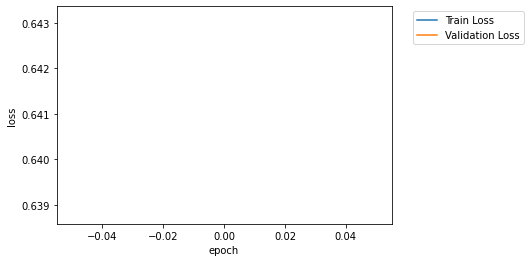

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 2
Epoch [2/50],Train Loss: 0.6351, Valid Loss: 0.71476147


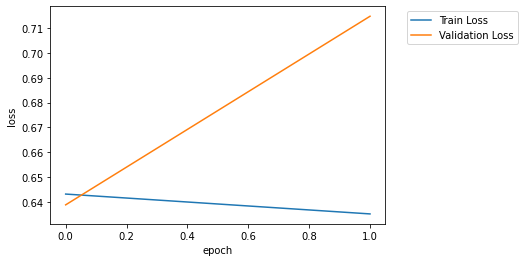

Starting epoch 3
Epoch [3/50],Train Loss: 0.6479, Valid Loss: 0.65949483


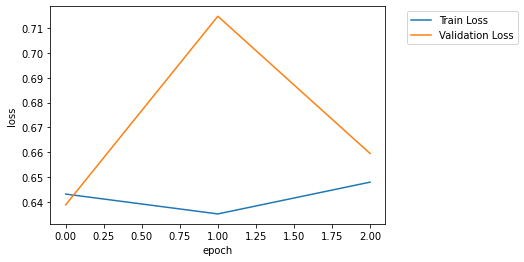

Starting epoch 4
Epoch [4/50],Train Loss: 0.6745, Valid Loss: 0.68150401


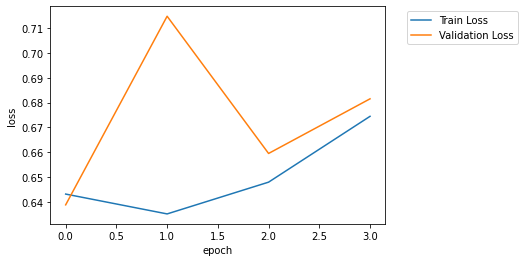

Starting epoch 5
Epoch [5/50],Train Loss: 0.6763, Valid Loss: 0.67242618


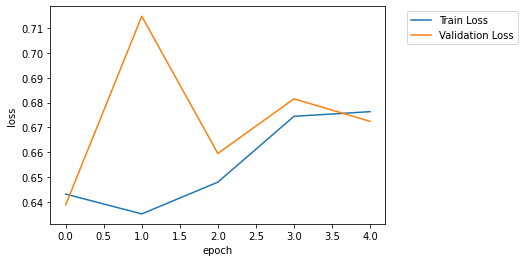

Starting epoch 6
Epoch [6/50],Train Loss: 0.6656, Valid Loss: 0.67176432


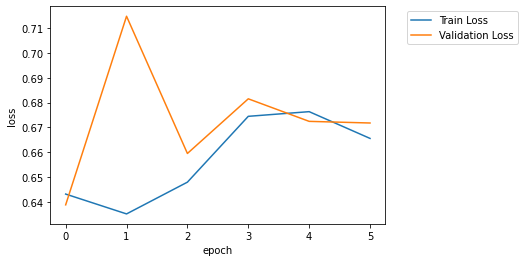

Starting epoch 7
Epoch [7/50],Train Loss: 0.6680, Valid Loss: 0.66982663


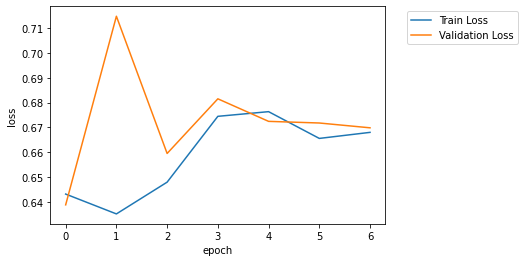

Starting epoch 8
Epoch [8/50],Train Loss: 0.6560, Valid Loss: 0.65589797


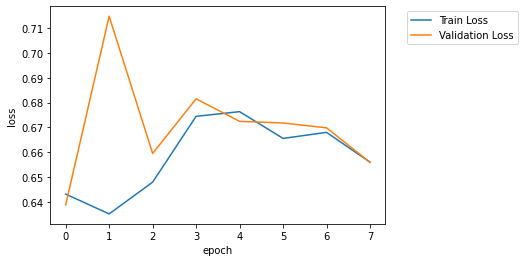

Starting epoch 9
Epoch [9/50],Train Loss: 0.6666, Valid Loss: 0.66423724


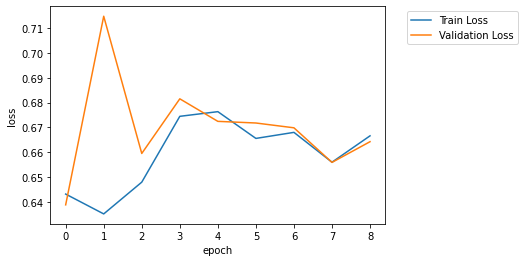

Starting epoch 10
Epoch [10/50],Train Loss: 0.6725, Valid Loss: 0.67553986


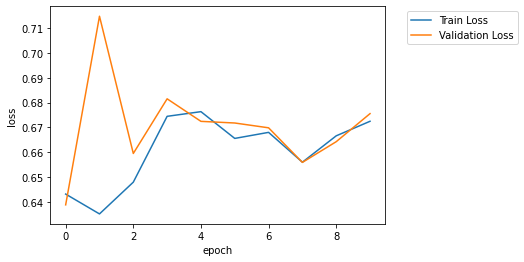

Starting epoch 11
Epoch [11/50],Train Loss: 0.6660, Valid Loss: 0.69430010


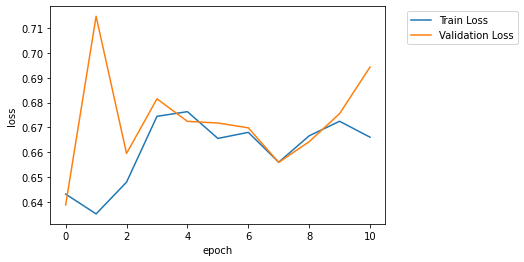

Starting epoch 12
Epoch [12/50],Train Loss: 0.6496, Valid Loss: 0.69519836


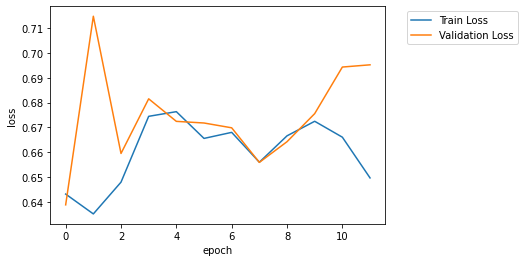

Starting epoch 13
Epoch [13/50],Train Loss: 0.6987, Valid Loss: 0.69342310


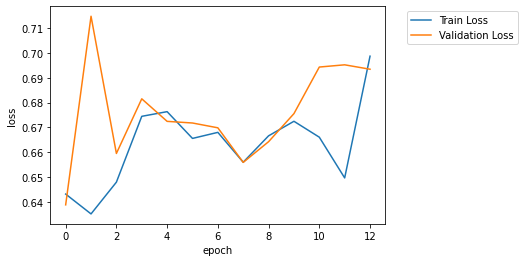

Starting epoch 14
Epoch [14/50],Train Loss: 0.6901, Valid Loss: 0.63972889


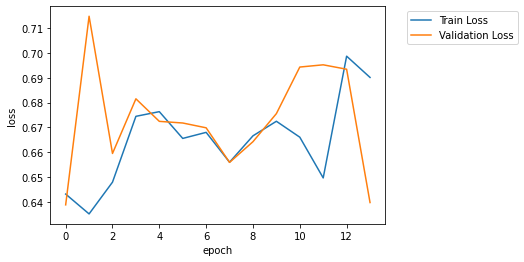

Starting epoch 15
Epoch [15/50],Train Loss: 0.6166, Valid Loss: 0.60523140


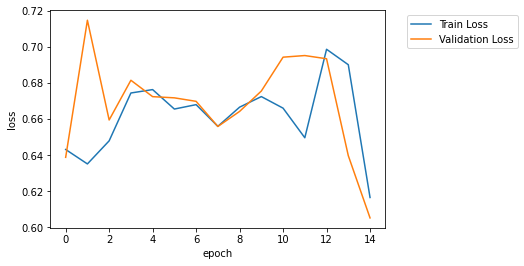

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 16
Epoch [16/50],Train Loss: 0.5745, Valid Loss: 0.56231305


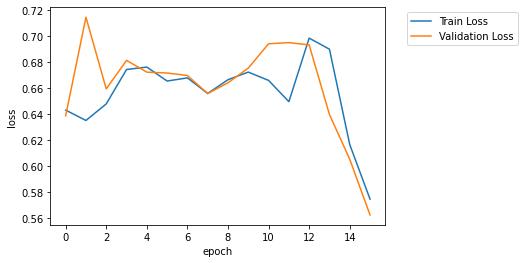

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 17
Epoch [17/50],Train Loss: 0.5256, Valid Loss: 0.51968535


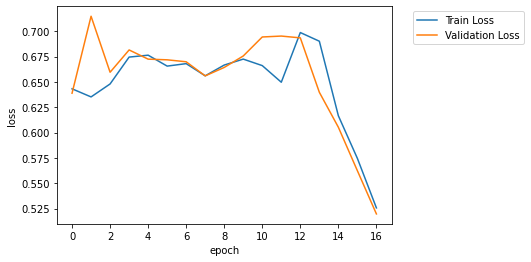

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 18
Epoch [18/50],Train Loss: 0.4813, Valid Loss: 0.48009910


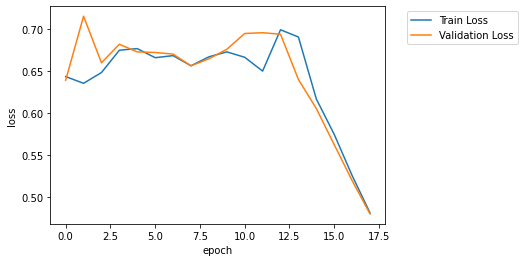

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 19
Epoch [19/50],Train Loss: 0.4482, Valid Loss: 0.43769020


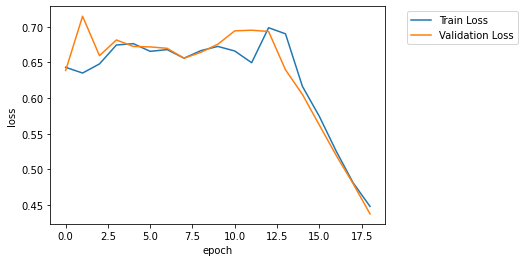

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 20
Epoch [20/50],Train Loss: 0.4073, Valid Loss: 0.39759194


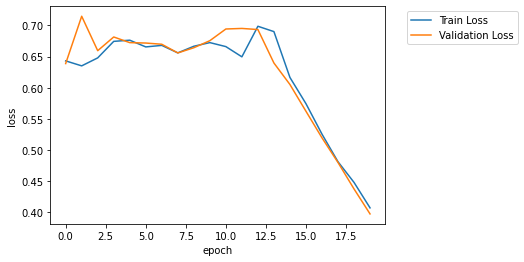

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 21
Epoch [21/50],Train Loss: 0.3892, Valid Loss: 0.39151399


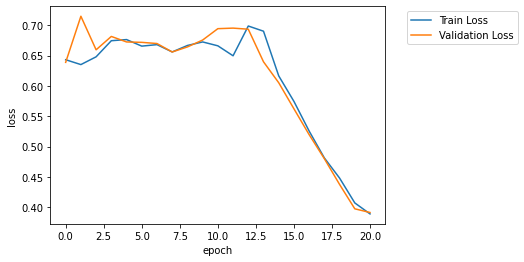

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 22
Epoch [22/50],Train Loss: 0.3653, Valid Loss: 0.37730384


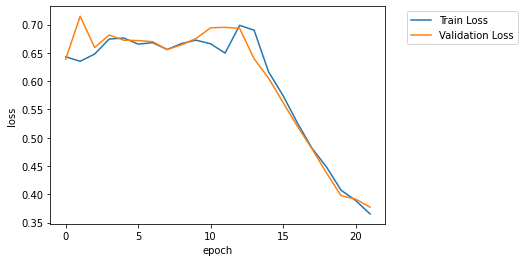

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 23
Epoch [23/50],Train Loss: 0.3430, Valid Loss: 0.33528375


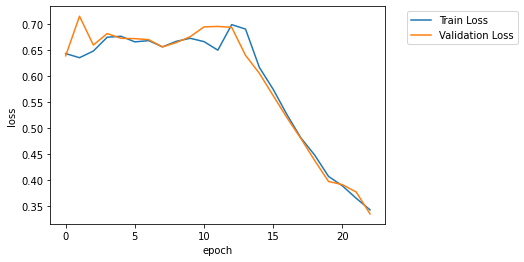

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 24
Epoch [24/50],Train Loss: 0.3079, Valid Loss: 0.31149266


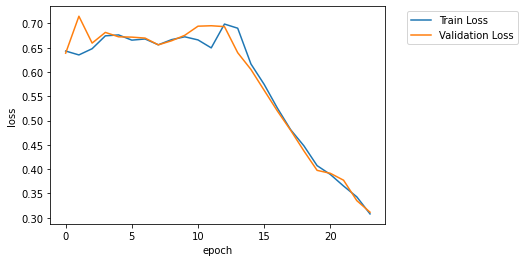

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 25
Epoch [25/50],Train Loss: 0.2856, Valid Loss: 0.28013135


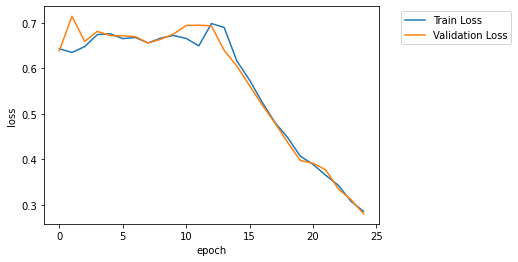

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 26
Epoch [26/50],Train Loss: 0.2693, Valid Loss: 0.27145716


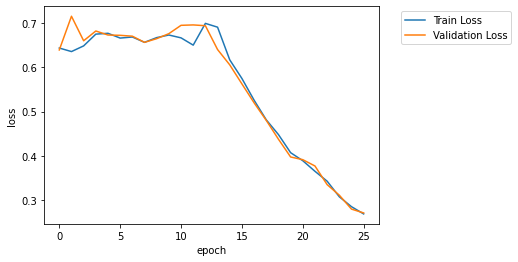

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 27
Epoch [27/50],Train Loss: 0.2576, Valid Loss: 0.25180284


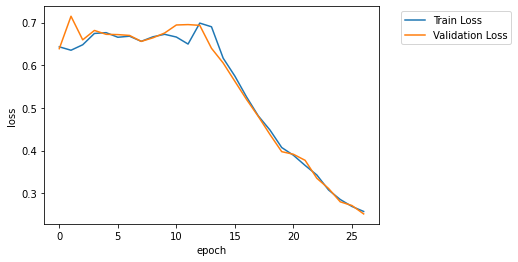

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 28
Epoch [28/50],Train Loss: 0.2331, Valid Loss: 0.24546512


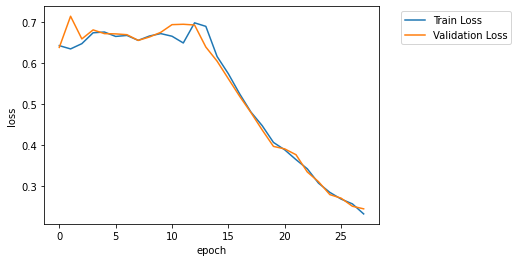

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 29
Epoch [29/50],Train Loss: 0.2242, Valid Loss: 0.21751982


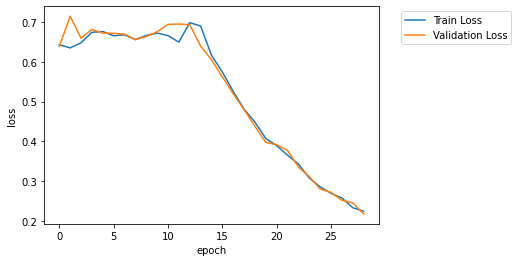

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 30
Epoch [30/50],Train Loss: 0.2086, Valid Loss: 0.21401505


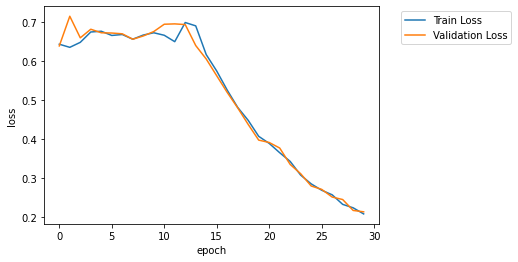

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 31
Epoch [31/50],Train Loss: 0.1937, Valid Loss: 0.18276253


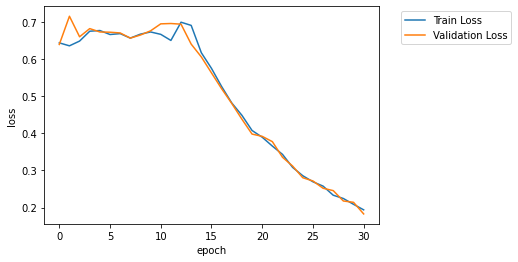

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 32
Epoch [32/50],Train Loss: 0.1806, Valid Loss: 0.17081815


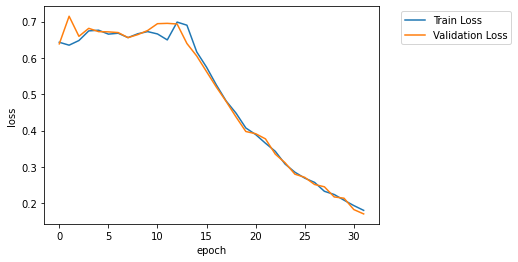

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 33
Epoch [33/50],Train Loss: 0.1722, Valid Loss: 0.16596035


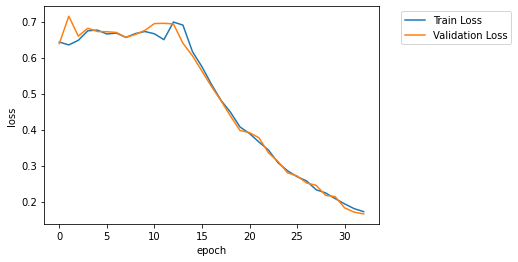

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 34
Epoch [34/50],Train Loss: 0.1650, Valid Loss: 0.16000743


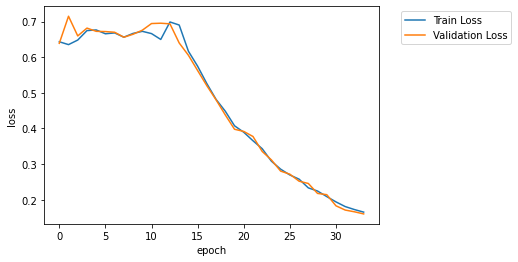

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 35
Epoch [35/50],Train Loss: 0.1598, Valid Loss: 0.15946029


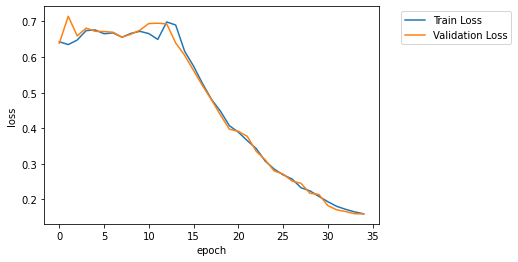

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 36
Epoch [36/50],Train Loss: 0.1527, Valid Loss: 0.15070772


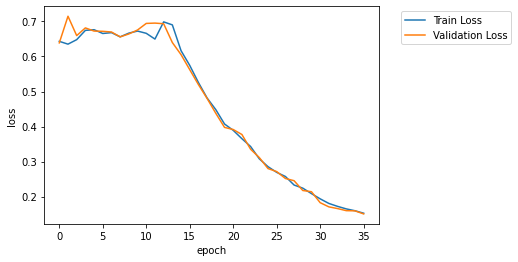

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 37
Epoch [37/50],Train Loss: 0.1570, Valid Loss: 0.14893880


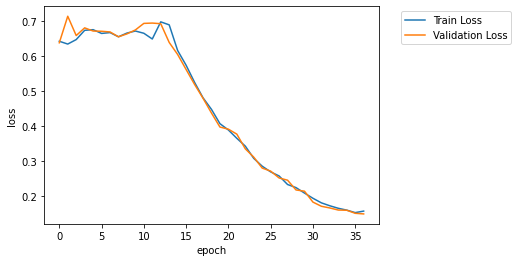

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 38
Epoch [38/50],Train Loss: 0.1564, Valid Loss: 0.15833527


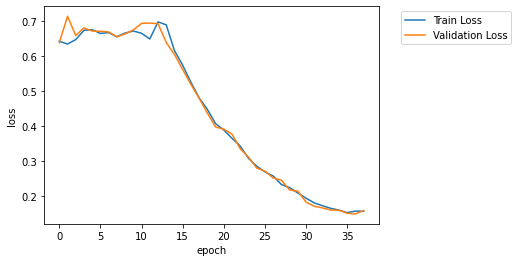

Starting epoch 39
Epoch [39/50],Train Loss: 0.1337, Valid Loss: 0.14300703


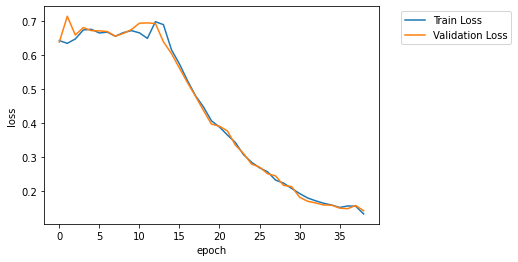

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 40
Epoch [40/50],Train Loss: 0.1163, Valid Loss: 0.13504043


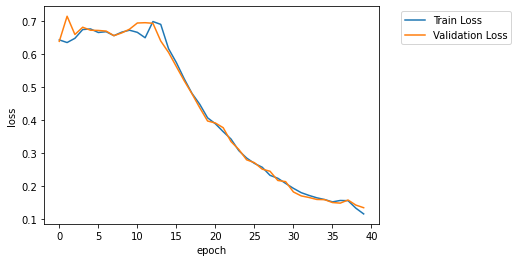

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 41
Epoch [41/50],Train Loss: 0.1265, Valid Loss: 0.11879354


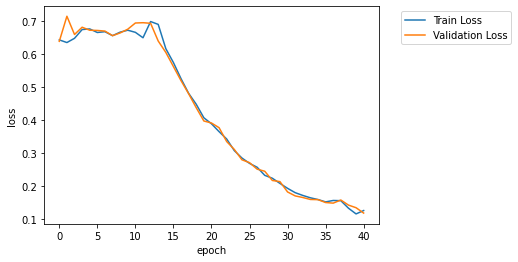

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 42
Epoch [42/50],Train Loss: 0.1243, Valid Loss: 0.13607013


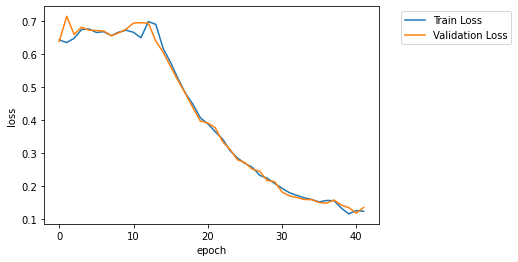

Starting epoch 43
Epoch [43/50],Train Loss: 0.1372, Valid Loss: 0.12844495


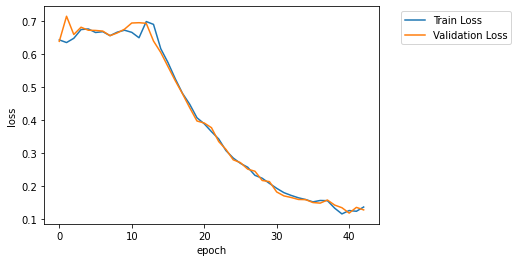

Starting epoch 44
Epoch [44/50],Train Loss: 0.1230, Valid Loss: 0.11170692


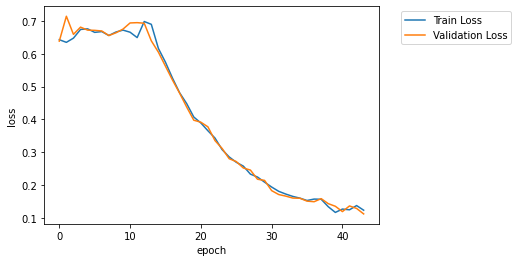

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 45
Epoch [45/50],Train Loss: 0.1225, Valid Loss: 0.11254640


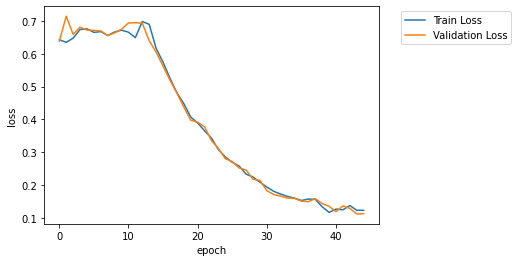

Starting epoch 46
Epoch [46/50],Train Loss: 0.1119, Valid Loss: 0.09793319


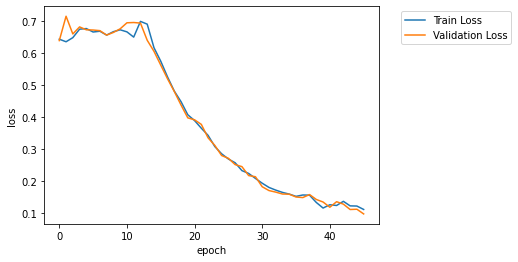

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 47
Epoch [47/50],Train Loss: 0.1103, Valid Loss: 0.10931636


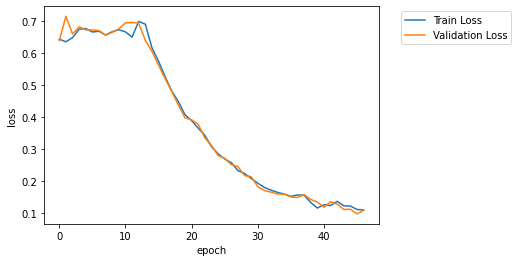

Starting epoch 48
Epoch [48/50],Train Loss: 0.0985, Valid Loss: 0.10183924


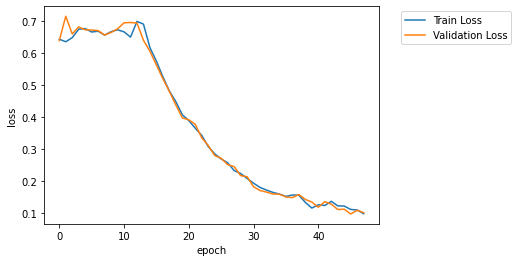

Starting epoch 49
Epoch [49/50],Train Loss: 0.1095, Valid Loss: 0.07965288


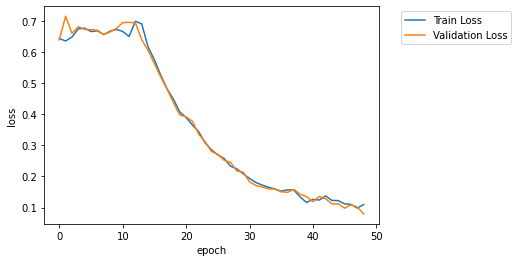

Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 50
Epoch [50/50],Train Loss: 0.0962, Valid Loss: 0.08502745


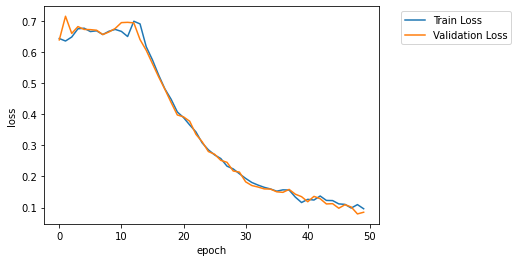

Finished Training


In [ ]:

import math 
from matplotlib import gridspec 

# actual training
import torch.optim as optim
lr = 0.0005

optimizer = optim.Adam(SNN.parameters(), lr = 0.0005)
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet.pt'
train_losses, val_losses = train(SNN, train_loader, val_loader, num_epochs, criterion, save_path)

#plotting of training and validation loss

# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label="Validation Loss")
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()



In [ ]:
cp /content/siameseNet-batchnorm50.pt /content/drive/MyDrive/ColabNotebooks/siameseNet-batchnorm50.pt

In [ ]:
# create the test set for final testing
testSize = 1000
numberOfWays = 2


test_set = NWaysEval(categories_test, root_dir_test, testSize, numberOfWays, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 0, shuffle=True)



# # Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0005)


#num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer) # load trained models' parameter into for eval


print(best_val_loss)
final_accuracy = eval(load_model, test_loader)


# results export
num_epochs = 50

export_attempt_data = {'Train Size' :train_size,
                         'Validation Size' : val_size,
                         'Test Size' : testSize,
                         'Image Size' : img_size,
                         'Number of Ways' : numberOfWays,
                         'Learning Rate' : lr,
                         'No. of Epoch' : num_epochs,
                         'Accuracy' : final_accuracy}


df = pd.DataFrame(export_attempt_data, index = None)
df.to_csv('/content/drive/MyDrive/ColabNotebooks/network_details_2.csv')



# create the test set for final testing
testSize = 1000
numberOfWays = 4

test_set = NWaysEval(categories_test, root_dir_test, testSize, numberOfWays, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 0, shuffle=True)



# # Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0005)


#num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer) # load trained models' parameter into for eval


print(best_val_loss)
final_accuracy = eval(load_model, test_loader)

# results export
num_epochs = 50

export_attempt_data = {'Train Size' :train_size,
                         'Validation Size' : val_size,
                         'Test Size' : testSize,
                         'Image Size' : img_size,
                         'Number of Ways' : numberOfWays,
                         'Learning Rate' : lr,
                         'No. of Epoch' : num_epochs,
                         'Accuracy' : final_accuracy}


df = pd.DataFrame(export_attempt_data, index = None)
df.to_csv('/content/drive/MyDrive/ColabNotebooks/network_details_4.csv')

# create the test set for final testing
testSize = 1000
numberOfWays = 8

test_set = NWaysEval(categories_test, root_dir_test, testSize, numberOfWays, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 0, shuffle=True)



# # Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0005)


#num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer) # load trained models' parameter into for eval


print(best_val_loss)
final_accuracy = eval(load_model, test_loader)

# results export
num_epochs = 50

export_attempt_data = {'Train Size' :train_size,
                         'Validation Size' : val_size,
                         'Test Size' : testSize,
                         'Image Size' : img_size,
                         'Number of Ways' : numberOfWays,
                         'Learning Rate' : lr,
                         'No. of Epoch' : num_epochs,
                         'Accuracy' : final_accuracy}


df = pd.DataFrame(export_attempt_data, index = None)
df.to_csv('/content/drive/MyDrive/ColabNotebooks/network_details_8.csv')


# create the test set for final testing
testSize = 1000
numberOfWays = 16

test_set = NWaysEval(categories_test, root_dir_test, testSize, numberOfWays, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 0, shuffle=True)



# # Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0005)


#num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer) # load trained models' parameter into for eval


print(best_val_loss)
final_accuracy = eval(load_model, test_loader)

# results export
num_epochs = 50

export_attempt_data = {'Train Size' :train_size,
                         'Validation Size' : val_size,
                         'Test Size' : testSize,
                         'Image Size' : img_size,
                         'Number of Ways' : numberOfWays,
                         'Learning Rate' : lr,
                         'No. of Epoch' : num_epochs,
                         'Accuracy' : final_accuracy}


df = pd.DataFrame(export_attempt_data, index = None)
df.to_csv('/content/drive/MyDrive/ColabNotebooks/network_details_16.csv')



Model loaded from <== siameseNet-batchnorm50.pt
0.0796528788174222
Starting Iteration
Current Count is: 20
Accuracy on n way: 0.9
Current Count is: 40
Accuracy on n way: 0.9
Current Count is: 60
Accuracy on n way: 0.85
Current Count is: 80
Accuracy on n way: 0.85
Current Count is: 100
Accuracy on n way: 0.85
Current Count is: 120
Accuracy on n way: 0.85
Current Count is: 140
Accuracy on n way: 0.8428571428571429
Current Count is: 160
Accuracy on n way: 0.85625
Current Count is: 180
Accuracy on n way: 0.8611111111111112
Current Count is: 200
Accuracy on n way: 0.855
Current Count is: 220
Accuracy on n way: 0.8454545454545455
Current Count is: 240
Accuracy on n way: 0.8333333333333334
Current Count is: 260
Accuracy on n way: 0.8423076923076923
Current Count is: 280
Accuracy on n way: 0.8285714285714286
Current Count is: 300
Accuracy on n way: 0.8333333333333334
Current Count is: 320
Accuracy on n way: 0.834375
Current Count is: 340
Accuracy on n way: 0.8352941176470589
Current Count is: 

# New Section